In [1]:
from sklearn.datasets import make_moons, make_classification, make_circles, make_blobs
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import numpy as np
from itertools import cycle, islice
import matplotlib
import warnings
from matplotlib.ticker import MaxNLocator
warnings.filterwarnings("ignore")
matplotlib.rcParams.update({'font.size': 20})

In [27]:
###Generate data for Binary Classification
def get_data(random_seed):
    np.random.seed(random_seed) 
    X,y = make_blobs(n_samples=400, centers=2, cluster_std=0.7)
    X[:,0] -= 9.3
    X[:,1] -= 2.5

    np.random.seed(1)
    pos_ids = np.where(y == 0)[0]
    neg_ids = np.where(y == 1)[0]
    ids1 = np.random.randint(0,len(pos_ids),5)
    ids2 = np.random.randint(0,len(neg_ids),5)
    p1 = pos_ids[ids1]
    p2 = neg_ids[ids2]

    ## generate labeled and unlabeled data
    l_ids = np.concatenate((p1 , p2))
    u_ids = np.array(list(set(np.arange(X.shape[0])) - set(l_ids)))
    l_data1, l_data2 = X[l_ids,0].reshape(-1,1), X[l_ids,1].reshape(-1,1)
    u_data1, u_data2 = X[u_ids,0].reshape(-1,1), X[u_ids,1].reshape(-1,1)
    labels = y[l_ids]
    return [l_data1, l_data2], [u_data1, u_data2], labels, X, y, [p1, p2]


In [26]:
import copy
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC,SVC, NuSVC
from sklearn.ensemble import RandomForestClassifier
from copy import deepcopy

def sel_ids_y(score, add_num = 10):
    ids_sort = np.argsort(score)
    add_id = np.zeros(score.shape[0])
    add_id[ids_sort[:add_num]] = -1
    add_id[ids_sort[-add_num:]] = 1
    return add_id
    
def update_train_untrain(sel_ids, train_data, train_labels, untrain_data, weights=None):
#     sel_ids = np.array(sel_ids, dtype='bool')
    add_ids = np.where(np.array(sel_ids) != 0)[0]
    untrain_ids = np.where(np.array(sel_ids) == 0)[0]
    add_datas = [d[add_ids] for d in untrain_data]
    new_train_data = [np.concatenate([d1, d2]) for d1,d2 in zip(train_data, add_datas)]
    add_y = [1 if sel_ids[idx] > 0 else 0 for idx in add_ids]
    new_train_y = np.concatenate([train_labels, add_y])
    new_untrain_data = [d[untrain_ids] for d in untrain_data]
    return new_train_data, new_train_y, new_untrain_data


def update_train(sel_ids, train_data, train_labels, untrain_data, pred_y):
    add_ids = np.where(np.array(sel_ids) != 0)[0]
    add_data = [d[add_ids] for d in untrain_data]
    new_train_data = [np.concatenate([d1, d2]) for d1,d2 in zip(train_data, add_data)]
    add_y = pred_y[add_ids]
    new_train_y = np.concatenate([train_labels, pred_y[add_ids]])
    return new_train_data, new_train_y


def spaco(l_data, lbls, u_data, iter_step = 1, gamma = 0.5):
    
    # initiate classifier
    clfs = []
    scores = []
    add_ids = []
    add_num = 6
    clfss = []
    for view in range(2):
        clfs.append(RandomForestClassifier())
        clfs[view].fit(l_data[view], lbls)
        scores.append(clfs[view].predict_proba(u_data[view]))
        add_ids.append(sel_ids_y(scores[view], add_num))
        #py = np.argmax(sum(scores, axis = 1))
    score = sum(scores)
    pred_y = np.argmax(sum(scores), axis = 1)
    for step in range(iter_step):
        for view in range(2):
            if add_num * 2 > u_data[0].shape[0]: break
            #update v
            ov = np.where(add_ids[1-view] != 0)[0]
            scores[view][ov] += add_ids[1-view][ov] * gamma
            add_ids[view] = sel_ids_y(scores[view], add_num)
            
            
            #update w
            nl_data, nlbls = update_train(add_ids[view], l_data, lbls, u_data, pred_y)
            clfs[view].fit(nl_data[view], nlbls)
            
            # update y, v
            scores[view] = clfs[view].predict_proba(u_data[view])
            add_num += 6
            scores[view][ov] += add_ids[1-view][ov] * gamma
            add_ids[view] = sel_ids_y(scores[view], add_num)
            
            
            score = sum(scores)
            
            pred_y = np.argmax(sum(scores), axis = 1)
            #py = [0  if s < 0 else 1 for s in scores[view]]
    return clfs

spaco experiment(gamma=3): 0.99500
spaco experiment(gamma=0.3): 0.98500


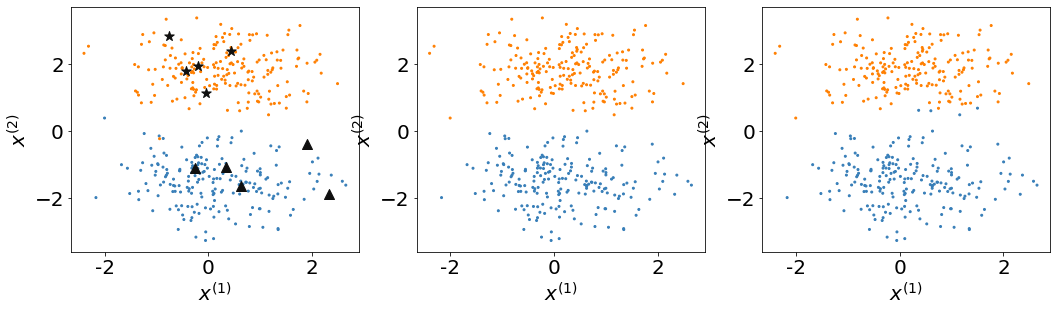

In [43]:
x = [-1.5,0,1.5]
my_xticks=[-2,0,2]

### Get data
ldata, udata, labels, X, y, label_ids = get_data(4)

### parameters
steps = 16
gamma = 3

### original fig
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y) + 3))))
fig = plt.figure(figsize=(16,4))
plt.subplots_adjust(bottom=.05, top=.9, left=.05, right=0.9)

ax = fig.add_subplot(131)
plt.scatter(X[:,0], X[:,1], marker='o', c=colors[y], s=4)
plt.scatter(X[label_ids[0],0], X[label_ids[0],1], marker='^', c='#0F0F0F', s=100)
plt.scatter(X[label_ids[1],0], X[label_ids[1],1], marker='*', c='#0F0F0F', s=100)
ax.set_xlabel('$x^{(1)}$')
ax.set_ylabel('$x^{(2)}$')
plt.xticks(x, my_xticks)
     
    
#### spaco experiment1 gamma=3
clfs = spaco(ldata, labels, udata, iter_step=steps, gamma=3)
score1 = clfs[0].predict_proba(X[:,0].reshape(-1,1))
score2 = clfs[1].predict_proba(X[:,1].reshape(-1,1))
score = score1 + score2
pred_y = np.argmax(score, axis = 1)
print('spaco experiment(gamma=3): %0.5f' % np.mean(pred_y == y))
ax = fig.add_subplot(132)    
ax.set_xlabel('$x^{(1)}$')
ax.set_ylabel('$x^{(2)}$')
plt.scatter(X[:,0], X[:,1], marker='o', c=colors[pred_y], s=4)
plt.xticks(x, my_xticks)


#### spaco experiment2 gamma=0.3
clfs = spaco(ldata, labels, udata, iter_step=steps, gamma=1)
score1 = clfs[0].predict_proba(X[:,0].reshape(-1,1))
score2 = clfs[1].predict_proba(X[:,1].reshape(-1,1))
score = score1 + score2
pred_y = np.argmax(score, axis = 1)
print('spaco experiment(gamma=0.3): %0.5f' % np.mean(pred_y == y))
ax = fig.add_subplot(133)    
ax.set_xlabel('$x^{(1)}$')
ax.set_ylabel('$x^{(2)}$')
plt.scatter(X[:,0], X[:,1], marker='o', c=colors[pred_y], s=4)
plt.xticks(x, my_xticks)

plt.show()

In [48]:
from sklearn.preprocessing import scale
scale( score, axis=1, with_mean=True, with_std=True, copy=True )

array([[-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [ 1., -1.],
       [ 1., -1.],
       [-1.,  1.],
       [-1.,  1.],
       [ 1., -1.],
       [ 1., -1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [ 1., -1.],
       [-1.,  1.],
       [ 1., -1.],
       [ 1., -1.],
       [ 1., -1.],
       [ 1., -1.],
       [ 1., -1.],
       [ 1., -1.],
       [ 1., -1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [ 1., -1.],
       [-1.,  1.],
       [-1.,  1.],
       [ 1., -1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [ 1., -1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [ 1., -1.],
       [ 1., -1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [ 1., -1.],
       [ 1.,

In [38]:
X_l = np.concatenate((ldata[0],ldata[1]), axis = 1)

In [40]:
rfc = RandomForestClassifier()
rfc.fit(X_l, labels)

RandomForestClassifier()

In [42]:
from sklearn.metrics import accuracy_score
rfc_pred = rfc.predict(X)
accuracy_score(rfc_pred, y)

0.985